# Setup

In [3]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices('GPU') 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4961562899745169885
xla_global_id: -1
]


[]

In [4]:
NUM_CLASSES = 8
BATCH_SIZE = 12
EPOCHS = 30
IMAGE_SIZE = 224

In [5]:
from tensorflow import keras

# Grab training and testing data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/car-brands/Car_Brand_Logos/Train",
    labels='inferred',
    label_mode='categorical',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/car-brands/Car_Brand_Logos/Test",
    labels='inferred',
    label_mode='categorical',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

train_ds.class_names

Found 2499 files belonging to 8 classes.
Found 397 files belonging to 8 classes.


['hyundai',
 'lexus',
 'mazda',
 'mercedes',
 'opel',
 'skoda',
 'toyota',
 'volkswagen']

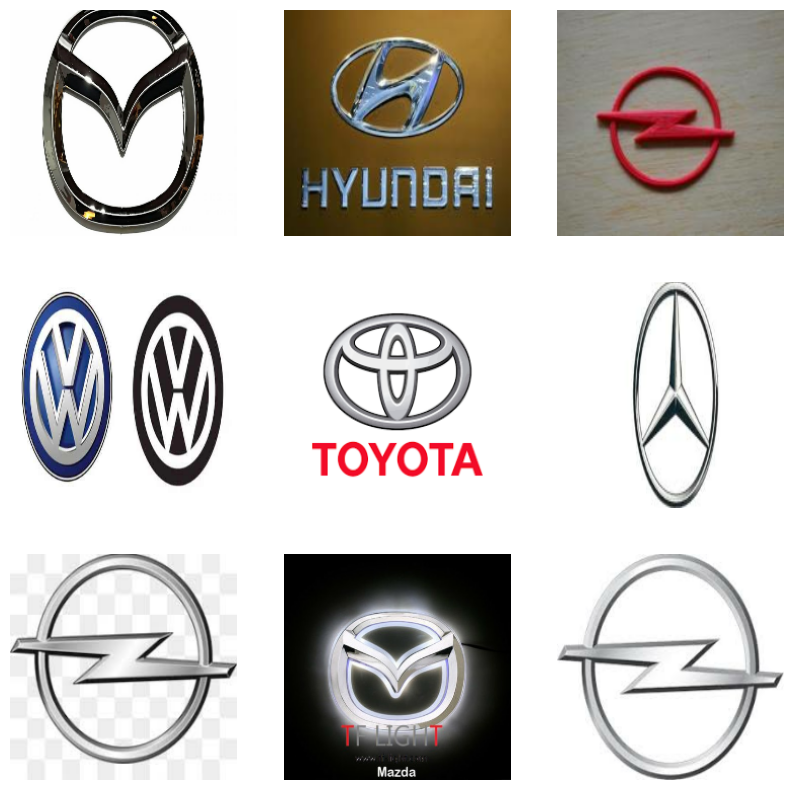

In [4]:
import matplotlib.pyplot as plt

# Visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Note to myself: 
# Tool to find most optimal hyperparameters with custom model
# source - https://github.com/keras-team/keras-tuner

# import keras_tuner

# def build_test_model(hp):
#     model = keras.Sequential()
#     model.add(layers.Rescaling(1.0 / 255))
#     model.add(layers.Conv2D(128, 3, strides=2, padding="same"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dense(
#         # Tune number of units.
#         units=hp.Int("units", min_value=32, max_value=512, step=32),
#         # Tune the activation function to use.
#         activation=hp.Choice("activation", ["relu", "tanh"]),
#     ))
#     model.add(keras.layers.Dense(1, activation='relu'))
#     model.compile(loss='categorical_crossentropy')
#     return model

# tuner = keras_tuner.RandomSearch(
#     build_test_model,
#     objective='val_loss',
#     max_trials=10)

# tuner.search(train_ds, epochs=10, validation_data=val_ds)
# best_model = tuner.get_best_models()[0]
# best_model.build(input_shape=(image_size, image_size, 3))
# best_model.summary()

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B0

# Using EfficientNet + Transfer Learning
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet
img_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),
    ],
    name="img_augmentation",
)

def build_model(num_classes, image_size):
    inputs = layers.Input(shape=(image_size, image_size, 3))
    x = img_augmentation(inputs)
    model = EfficientNetV2B0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

efficientnet_model = build_model(NUM_CLASSES, IMAGE_SIZE)
efficientnet_model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 rescaling_9 (Rescaling)        (None, 224, 224, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  0          ['rescaling_9[0][0]'] 

# Train

In [27]:
# https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python
from keras.callbacks import CSVLogger

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    CSVLogger('training.log', separator=',', append=False)
]

In [28]:
# Use GPU
with tf.device('/GPU:0'):
    history = efficientnet_model.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        validation_data=val_ds,
    )

Epoch 1/30


2023-07-26 20:53:31.089344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 88/209 [===========>..................] - ETA: 7s - loss: 2.1888 - accuracy: 0.2907

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 25s 77ms/step - loss: 1.7718 - accuracy: 0.4282 - val_loss: 1.1529 - val_accuracy: 0.6348
Epoch 2/30
 88/209 [===========>..................] - ETA: 6s - loss: 1.2008 - accuracy: 0.6155

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 71ms/step - loss: 1.1354 - accuracy: 0.6367 - val_loss: 1.0288 - val_accuracy: 0.6751
Epoch 3/30
 88/209 [===========>..................] - ETA: 6s - loss: 1.0437 - accuracy: 0.6676

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 69ms/step - loss: 1.0233 - accuracy: 0.6723 - val_loss: 1.0027 - val_accuracy: 0.7103
Epoch 4/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.9331 - accuracy: 0.7112

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 71ms/step - loss: 0.9457 - accuracy: 0.7067 - val_loss: 1.0006 - val_accuracy: 0.6877
Epoch 5/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.8588 - accuracy: 0.7273

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 67ms/step - loss: 0.8820 - accuracy: 0.7171 - val_loss: 0.8896 - val_accuracy: 0.7305
Epoch 6/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.8131 - accuracy: 0.7396

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 71ms/step - loss: 0.8203 - accuracy: 0.7379 - val_loss: 0.9036 - val_accuracy: 0.7355
Epoch 7/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.8311 - accuracy: 0.7358

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 68ms/step - loss: 0.8093 - accuracy: 0.7375 - val_loss: 0.9148 - val_accuracy: 0.7254
Epoch 8/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.8077 - accuracy: 0.7348

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 70ms/step - loss: 0.7871 - accuracy: 0.7427 - val_loss: 0.9076 - val_accuracy: 0.7406
Epoch 9/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7178 - accuracy: 0.7812

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 67ms/step - loss: 0.7393 - accuracy: 0.7639 - val_loss: 0.9872 - val_accuracy: 0.7229
Epoch 10/30
 88/209 [===========>..................] - ETA: 7s - loss: 0.7642 - accuracy: 0.7547

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 70ms/step - loss: 0.7649 - accuracy: 0.7543 - val_loss: 0.8891 - val_accuracy: 0.7531
Epoch 11/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7905 - accuracy: 0.7576

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 68ms/step - loss: 0.7918 - accuracy: 0.7439 - val_loss: 0.8687 - val_accuracy: 0.7204
Epoch 12/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7566 - accuracy: 0.7500

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 70ms/step - loss: 0.7775 - accuracy: 0.7495 - val_loss: 0.8479 - val_accuracy: 0.7456
Epoch 13/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7482 - accuracy: 0.7661

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 67ms/step - loss: 0.7480 - accuracy: 0.7639 - val_loss: 0.8906 - val_accuracy: 0.7305
Epoch 14/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7686 - accuracy: 0.7547

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 71ms/step - loss: 0.7640 - accuracy: 0.7523 - val_loss: 0.8727 - val_accuracy: 0.7456
Epoch 15/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.6765 - accuracy: 0.7756

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 67ms/step - loss: 0.6914 - accuracy: 0.7719 - val_loss: 0.9062 - val_accuracy: 0.7406
Epoch 16/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.6534 - accuracy: 0.7955

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 69ms/step - loss: 0.7089 - accuracy: 0.7723 - val_loss: 0.8895 - val_accuracy: 0.7406
Epoch 17/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7379 - accuracy: 0.7689

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 68ms/step - loss: 0.7192 - accuracy: 0.7663 - val_loss: 0.9369 - val_accuracy: 0.7280
Epoch 18/30
 88/209 [===========>..................] - ETA: 7s - loss: 0.7121 - accuracy: 0.7670

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 70ms/step - loss: 0.7327 - accuracy: 0.7635 - val_loss: 0.9681 - val_accuracy: 0.7305
Epoch 19/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.6509 - accuracy: 0.7803

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 66ms/step - loss: 0.6657 - accuracy: 0.7859 - val_loss: 0.9722 - val_accuracy: 0.7406
Epoch 20/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.6766 - accuracy: 0.7737

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 68ms/step - loss: 0.7207 - accuracy: 0.7611 - val_loss: 0.9190 - val_accuracy: 0.7531
Epoch 21/30
 88/209 [===========>..................] - ETA: 7s - loss: 0.6909 - accuracy: 0.7737

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 72ms/step - loss: 0.7139 - accuracy: 0.7691 - val_loss: 0.9733 - val_accuracy: 0.7406
Epoch 22/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7154 - accuracy: 0.7708

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 67ms/step - loss: 0.6896 - accuracy: 0.7747 - val_loss: 0.9125 - val_accuracy: 0.7456
Epoch 23/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.6944 - accuracy: 0.7775

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 70ms/step - loss: 0.6840 - accuracy: 0.7811 - val_loss: 0.9301 - val_accuracy: 0.7456
Epoch 24/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.6808 - accuracy: 0.7718

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 67ms/step - loss: 0.6992 - accuracy: 0.7763 - val_loss: 0.8972 - val_accuracy: 0.7481
Epoch 25/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7056 - accuracy: 0.7775

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 70ms/step - loss: 0.7233 - accuracy: 0.7727 - val_loss: 0.9191 - val_accuracy: 0.7330
Epoch 26/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7042 - accuracy: 0.7680

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 67ms/step - loss: 0.6864 - accuracy: 0.7751 - val_loss: 0.9224 - val_accuracy: 0.7683
Epoch 27/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7123 - accuracy: 0.7595

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 71ms/step - loss: 0.7076 - accuracy: 0.7627 - val_loss: 0.9173 - val_accuracy: 0.7607
Epoch 28/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.6708 - accuracy: 0.7812

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 14s 68ms/step - loss: 0.6864 - accuracy: 0.7811 - val_loss: 0.8877 - val_accuracy: 0.7582
Epoch 29/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.6731 - accuracy: 0.7746

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 70ms/step - loss: 0.6688 - accuracy: 0.7775 - val_loss: 0.9267 - val_accuracy: 0.7431
Epoch 30/30
 88/209 [===========>..................] - ETA: 6s - loss: 0.7004 - accuracy: 0.7803

Corrupt JPEG data: 7 extraneous bytes before marker 0xee


209/209 [==============================] - 15s 72ms/step - loss: 0.7323 - accuracy: 0.7659 - val_loss: 0.8706 - val_accuracy: 0.7481


In [29]:
efficientnet_model.save('efficientnet_model')

In [9]:
!ls
model = keras.models.load_model('efficientnet_model')

efficientnet_model  save_at_19.keras  save_at_3.keras
model.png	    save_at_2.keras   save_at_30.keras
save_at_1.keras     save_at_20.keras  save_at_4.keras
save_at_10.keras    save_at_21.keras  save_at_5.keras
save_at_11.keras    save_at_22.keras  save_at_6.keras
save_at_12.keras    save_at_23.keras  save_at_7.keras
save_at_13.keras    save_at_24.keras  save_at_8.keras
save_at_14.keras    save_at_25.keras  save_at_9.keras
save_at_15.keras    save_at_26.keras  untitled_project
save_at_16.keras    save_at_27.keras  xception_car_logos_model
save_at_17.keras    save_at_28.keras  xception_car_logos_model.zip
save_at_18.keras    save_at_29.keras


# Predict

In [10]:
import numpy as np

img = keras.utils.load_img(
    "../input/car-brands/Car_Brand_Logos/Test/volkswagen/images40.jpg", target_size=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
prediction_values = predictions.flatten()
print(np.column_stack((train_ds.class_names, prediction_values)))

max_val_index = max((v, i) for i, v in enumerate(predictions.flatten()))[1]

print(f"This car is a {train_ds.class_names[max_val_index]}")

1/1 [==============================] - 2s 2s/step
[['hyundai' '1.5718755e-06']
 ['lexus' '6.726227e-06']
 ['mazda' '9.7552736e-08']
 ['mercedes' '1.3972286e-06']
 ['opel' '6.904743e-07']
 ['skoda' '0.0019169967']
 ['toyota' '1.7099801e-06']
 ['volkswagen' '0.9980708']]
This car is a volkswagen


# Analyze

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

import pandas as pd
history = pd.read_csv('training.log', sep=',', engine='python')
plot_hist(history)

In [11]:
# Download Model
!pwd
!zip -r efficientnet_model.zip /kaggle/working/efficientnet_model

from IPython.display import FileLink
FileLink(r'efficientnet_model.zip')

/kaggle/working
  adding: kaggle/working/efficientnet_model/ (stored 0%)
  adding: kaggle/working/efficientnet_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/efficientnet_model/variables/ (stored 0%)
  adding: kaggle/working/efficientnet_model/variables/variables.index (deflated 78%)
  adding: kaggle/working/efficientnet_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/efficientnet_model/keras_metadata.pb (deflated 95%)
  adding: kaggle/working/efficientnet_model/saved_model.pb (deflated 91%)


/kaggle/working/efficientnet_model.zip